In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score

import spacy

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('../final_data.csv', encoding='latin1')

## Shuffle dataset and split into train, valoidation and test datasets

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19867 entries, 0 to 19866
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   posterID        19867 non-null  object 
 1   Genre           19835 non-null  object 
 2   overview        19833 non-null  object 
 3   IMDB Score      19860 non-null  float64
 4   director        19867 non-null  object 
 5   actors          18912 non-null  object 
 6   runtime         19865 non-null  float64
 7   num_faces       19867 non-null  float64
 8   brightness      19867 non-null  float64
 9   saturation      19867 non-null  float64
 10  hue             19867 non-null  float64
 11  brightness_sd   19867 non-null  float64
 12  saturation_sd   19867 non-null  float64
 13  hue_sd          19867 non-null  float64
 14  blue            19867 non-null  float64
 15  blue_sd         19867 non-null  float64
 16  green           19867 non-null  float64
 17  green_sd        19867 non-null 

In [4]:
df = df.dropna().reset_index(drop=True)

In [5]:
df = df.rename(columns={'IMDB Score': 'imdb_score'})

In [6]:
cols = ['posterID', 'Genre', 'overview', 'director', 'actors',
       'runtime', 'num_faces', 'brightness', 'saturation', 'hue',
       'brightness_sd', 'saturation_sd ', 'hue_sd', 'blue', 'blue_sd', 'green',
       'green_sd', 'red', 'red_sd ']

In [7]:
def split_dataset(data, train_size=0.7):
    X_train, RX = train_test_split(data, test_size=1-train_size, random_state=0)
    X_val, X_test = train_test_split(RX, test_size=0.5, random_state=0)
    
    return X_train, X_val, X_test

In [8]:
X_train, X_val, X_test = split_dataset(df)

In [9]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(13194, 20)
(2828, 20)
(2828, 20)


In [10]:
X_train.to_csv('../data/X_train.csv', index=False)
X_val.to_csv('../data/X_val.csv', index=False)
X_test.to_csv('../data/X_test.csv', index=False)

# Encoding

In [2]:
X_train = pd.read_csv('../data/X_train.csv', encoding='latin1')
X_val = pd.read_csv('../data/X_val.csv', encoding='latin1')
X_test = pd.read_csv('../data/X_test.csv', encoding='latin1')

In [3]:
def split_words(s, tokenizer=None):
    if tokenizer:
        words = tokenizer(s)
        return [i.text for i in words]
    else:
        return s.lower().split('|')

def get_dict(data, min_count=5, tokenizer=None):
    count = {}
    for s in data:
        words = split_words(s, tokenizer)
        for word in set(words):
            if word in count:
                count[word] += 1
            else:
                count[word] = 1
                
    for word in list(count.keys()):
        if count[word] < min_count:
            del count[word]
            
    for i, word in enumerate(count.keys()):
        count[word] = i
    
    return count

def transform_text(data, word_count, tokenizer= None):
    tr = np.zeros((len(data), len(word_count)))
    
    for i in range(len(data)):
        words = split_words(data[i], tokenizer)
        for word in words:
            if word in word_count:
                tr[i][word_count[word]] += 1
            
    return tr

In [12]:
genre_count = get_dict(X_train.Genre.astype(str))

genre_train = transform_text(X_train.Genre, genre_count)
genre_val = transform_text(X_val.Genre, genre_count)
genre_test = transform_text(X_test.Genre, genre_count)

print(genre_train.shape)
print(genre_val.shape)
print(genre_test.shape)
print(len(genre_count))

(13194, 23)
(2828, 23)
(2828, 23)
23


In [13]:
dir_count = get_dict(X_train.director.astype(str))

dir_train = transform_text(X_train.director, dir_count)
dir_val = transform_text(X_val.director, dir_count)
dir_test = transform_text(X_test.director, dir_count)

print(dir_train.shape)
print(dir_val.shape)
print(dir_test.shape)
print(len(dir_count))

(13194, 491)
(2828, 491)
(2828, 491)
491


In [14]:
actor_count = get_dict(X_train.actors.astype(str))

actor_train = transform_text(X_train.actors, actor_count)
actor_val = transform_text(X_val.actors, actor_count)
actor_test = transform_text(X_test.actors, actor_count)

print(actor_train.shape)
print(actor_val.shape)
print(actor_test.shape)
print(len(actor_count))

(13194, 1671)
(2828, 1671)
(2828, 1671)
1671


In [15]:
tokenizer = spacy.load("en_core_web_sm", disable=["tagger", "parser", "ner"])

overview_count = get_dict(X_train.overview.astype(str), min_count=20, tokenizer=tokenizer)

overview_train = transform_text(X_train.overview, overview_count, tokenizer=tokenizer)
overview_val = transform_text(X_val.overview, overview_count, tokenizer=tokenizer)
overview_test = transform_text(X_test.overview, overview_count, tokenizer=tokenizer)

print(overview_train.shape)
print(overview_val.shape)
print(overview_test.shape)
print(len(overview_count))

(13194, 3712)
(2828, 3712)
(2828, 3712)
3712


In [23]:
train_data =  pd.concat([X_train, pd.DataFrame(genre_train, columns=genre_count.keys()),
          pd.DataFrame(dir_train, columns=dir_count.keys()),
          pd.DataFrame(actor_train, columns=actor_count.keys()),
          pd.DataFrame(overview_train, columns=overview_count.keys())], axis = 1)

val_data =  pd.concat([X_val, pd.DataFrame(genre_val, columns=genre_count.keys()),
          pd.DataFrame(dir_val, columns=dir_count.keys()),
          pd.DataFrame(actor_val, columns=actor_count.keys()),
          pd.DataFrame(overview_val, columns=overview_count.keys())], axis = 1)

test_data =  pd.concat([X_test, pd.DataFrame(genre_test, columns=genre_count.keys()),
          pd.DataFrame(dir_test, columns=dir_count.keys()),
          pd.DataFrame(actor_test, columns=actor_count.keys()),
          pd.DataFrame(overview_test, columns=overview_count.keys())], axis = 1)

In [24]:
train_data = train_data.drop(columns=['Genre', 'overview', 'director', 'actors'])
val_data = val_data.drop(columns=['Genre', 'overview', 'director', 'actors'])
test_data = test_data.drop(columns=['Genre', 'overview', 'director', 'actors'])

In [27]:
train_data.shape

(13194, 5910)

In [ ]:
train_data.to_csv('../data/train_final.csv', index=False)
val_data.to_csv('../data/val_final.csv', index=False)
test_data.to_csv('../data/test_final.csv', index=False)

In [4]:
train_data = pd.read_csv('../data/train_final.csv', encoding='latin1')
val_data = pd.read_csv('../data/val_final.csv', encoding='latin1')
test_data = pd.read_csv('../data/test_final.csv', encoding='latin1')

In [5]:
train_data

,posterID,imdb_score,runtime,num_faces,brightness,saturation,hue,brightness_sd,saturation_sd,hue_sd,...,subway,cities,excitement,monstrous,May,traps,traffic,heir,fearless,eliminate
0,118747.jpg,4.8,123.0,0.0,121.583033,62.248667,120.589860,98.161753,57.907563,40.760182,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,118002.jpg,5.2,96.0,0.0,72.587666,83.177751,51.144231,56.498982,55.874362,60.854732,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,245407.jpg,5.9,112.0,0.0,221.694481,57.421970,43.001210,49.501003,59.513949,53.704714,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,101702.jpg,2.7,97.0,0.0,164.594473,85.856077,39.782188,84.970622,74.797138,51.705340,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4717798.jpg,6.5,79.0,0.0,131.897532,141.154133,56.524746,70.349874,78.879589,53.644487,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13189,453508.jpg,8.6,81.0,0.0,130.180970,143.553735,32.213240,58.971763,47.963068,27.805569,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13190,197256.jpg,5.7,105.0,0.0,96.603227,61.878834,66.051132,94.566402,79.445453,58.006236,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13191,1534084.jpg,4.5,100.0,0.0,152.397737,58.010025,27.310645,66.997014,47.144934,20.478903,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13192,1621446.jpg,4.3,90.0,0.0,68.851361,62.678879,80.704260,79.846216,63.411827,43.294419,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
for col in ['runtime','num_faces','hue','hue_sd','saturation','saturation_sd ','brightness','brightness_sd',
            'blue','blue_sd','green','green_sd','red','red_sd ']:
    mean_feature = np.mean(train_data[col])
    sd_feature = np.std(train_data[col])
    
    if sd_feature != 0:
        train_data[col] = (train_data[col] - mean_feature) / sd_feature
        val_data[col] = (val_data[col] - mean_feature) / sd_feature
        test_data[col] = (test_data[col] - mean_feature) / sd_feature
    else:
        train_data[col] = (train_data[col] - mean_feature) 
        val_data[col] = (val_data[col] - mean_feature) 
        test_data[col] = (test_data[col] - mean_feature)

In [7]:
train_data

,posterID,imdb_score,runtime,num_faces,brightness,saturation,hue,brightness_sd,saturation_sd,hue_sd,...,subway,cities,excitement,monstrous,May,traps,traffic,heir,fearless,eliminate
0,118747.jpg,4.8,0.783686,-0.216658,-0.211632,-0.832558,2.121743,1.853820,-0.387582,-0.339980,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,118002.jpg,5.2,-0.044494,-0.216658,-1.197686,-0.371092,-0.279790,-0.896663,-0.498212,0.927495,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,245407.jpg,5.9,0.446279,-0.216658,1.803157,-0.938981,-0.561388,-1.358654,-0.300175,0.476504,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,101702.jpg,2.7,-0.013821,-0.216658,0.653993,-0.312038,-0.672706,0.982971,0.531417,0.350392,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4717798.jpg,6.5,-0.565941,-0.216658,-0.004048,0.907230,-0.093724,0.017742,0.753552,0.472705,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13189,453508.jpg,8.6,-0.504594,-0.216658,-0.038594,0.960138,-0.934452,-0.733416,-0.928683,-1.157100,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13190,197256.jpg,5.7,0.231566,-0.216658,-0.714362,-0.840712,0.235713,1.616463,0.784342,0.747825,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13191,1534084.jpg,4.5,0.078199,-0.216658,0.408528,-0.926015,-1.103991,-0.203606,-0.973200,-1.619233,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13192,1621446.jpg,4.3,-0.228534,-0.216658,-1.272881,-0.823072,0.742440,0.644669,-0.088083,-0.180132,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
print(np.cov(train_data.imdb_score))
print(np.cov(val_data.imdb_score))
print(np.cov(test_data.imdb_score))

1.4771817495212598
1.4264534852595883
1.4920414168987786


In [9]:
train_X = train_data.drop(columns=['imdb_score', 'posterID'])
val_X = val_data.drop(columns=['imdb_score', 'posterID'])
test_X = test_data.drop(columns=['imdb_score', 'posterID'])
train_y = train_data.imdb_score
val_y = val_data.imdb_score
test_y = test_data.imdb_score

### classification setup

In [10]:
# classified to the nearest pt in {1, 3, 5, 7, 9}
def to_5_classes(y): 
    classes = np.ceil(y/2)
    return classes

def cls_5_to_value(cls):
    new_y = cls * 2 - 1
    return new_y

# classified to the nearest pt in {0.5, 1.5, 2.5, ... , 8.5, 9.5}
def to_10_classes(y):
    classes = np.ceil(y)
    return classes

def cls_10_to_value(cls):
    new_y = cls * 1 - 0.5
    return new_y
  
# classified to the nearest pt in {0.25, 0.75, 1.25, 1.75, ... , 9.25, 9.75}
def to_20_classes(y):
    classes = np.ceil(y*2)
    return classes

def cls_20_to_value(cls):
    new_y = cls * (1/2) - 0.25
    return new_y

In [11]:
train_y_5_cls = train_y.apply(to_5_classes)
train_y_10_cls = train_y.apply(to_10_classes)
train_y_20_cls = train_y.apply(to_20_classes)

val_y_5_cls = val_y.apply(to_5_classes)
val_y_10_cls = val_y.apply(to_10_classes)
val_y_20_cls = val_y.apply(to_20_classes)

test_y_5_cls = test_y.apply(to_5_classes)
test_y_10_cls = test_y.apply(to_10_classes)
test_y_20_cls = test_y.apply(to_20_classes)

# Linear Models

### regression

In [13]:
reg = LinearRegression(normalize=True).fit(train_X, train_y)

print('train r^2: ', reg.score(train_X, train_y))
print('train mse: ', mean_squared_error(reg.predict(train_X), train_y))

print('valid r^2: ', reg.score(val_X, val_y))
print('valid mse: ', mean_squared_error(reg.predict(val_X), val_y))

print('test r^2: ', reg.score(test_X, test_y))
print('test mse: ', mean_squared_error(reg.predict(test_X), test_y))

train r^2:  0.7043745159228347
train mse:  0.4366594719572778
valid r^2:  0.0058534409210745375
valid mse:  1.4176023729169114
test r^2:  0.06682427295388171
test mse:  1.391844494240012


In [23]:
ridgeReg = Ridge(alpha = 10, random_state = 0).fit(train_X, train_y)

print('train r^2: ', ridgeReg.score(train_X, train_y))
print('train mse: ', mean_squared_error(ridgeReg.predict(train_X), train_y))

print('valid r^2: ', ridgeReg.score(val_X, val_y))
print('valid mse: ', mean_squared_error(ridgeReg.predict(val_X), val_y))

print('test r^2: ', ridgeReg.score(test_X, test_y))
print('test mse: ', mean_squared_error(ridgeReg.predict(test_X), test_y))

train r^2:  0.6389160207073561
train mse:  0.5333462377993188
valid r^2:  0.28712903556613334
valid mse:  1.016517697049925
test r^2:  0.34131220992775924
test mse:  0.9824419425665801


### classification 

In [31]:
logReg_5_cls = LogisticRegression(penalty='none', solver='lbfgs',multi_class='multinomial').fit(train_X, train_y_5_cls)

train_y_5_pred = np.apply_along_axis(cls_5_to_value, 0, logReg_5_cls.predict(train_X))
val_y_5_pred = np.apply_along_axis(cls_5_to_value, 0, logReg_5_cls.predict(val_X))
test_y_5_pred = np.apply_along_axis(cls_5_to_value, 0, logReg_5_cls.predict(test_X))

print('Train accuracy: ', logReg_5_cls.score(train_X, train_y_5_cls))
print('Train MSE: ', mean_squared_error(train_y_5_pred, train_y_5_cls.apply(cls_5_to_value)))

print('Valid accuracy: ', logReg_5_cls.score(val_X, val_y_5_cls))
print('Valid MSE: ', mean_squared_error(val_y_5_pred, val_y_5_cls.apply(cls_5_to_value)))

print('Test accuracy: ', logReg_5_cls.score(test_X, test_y_5_cls))
print('Test MSE: ', mean_squared_error(test_y_5_pred, test_y_5_cls.apply(cls_5_to_value)))

Train accuracy:  0.8614521752311657
Train MSE:  0.6599969683189328
Valid accuracy:  0.5753182461103253
Valid MSE:  2.113154172560113
Test accuracy:  0.5823903818953324
Test MSE:  2.0438472418670437


In [32]:
logReg_10_cls = LogisticRegression(penalty='none', solver='lbfgs',multi_class='multinomial').fit(train_X, train_y_10_cls)

train_y_10_pred = np.apply_along_axis(cls_10_to_value, 0, logReg_10_cls.predict(train_X))
val_y_10_pred = np.apply_along_axis(cls_10_to_value, 0, logReg_10_cls.predict(val_X))
test_y_10_pred = np.apply_along_axis(cls_10_to_value, 0, logReg_10_cls.predict(test_X))

print('Train accuracy: ', logReg_10_cls.score(train_X, train_y_10_cls))
print('Train MSE: ', mean_squared_error(train_y_10_pred, train_y_10_cls.apply(cls_10_to_value)))

print('Valid accuracy: ', logReg_10_cls.score(val_X, val_y_10_cls))
print('Valid MSE: ', mean_squared_error(val_y_10_pred, val_y_10_cls.apply(cls_10_to_value)))

print('Test accuracy: ', logReg_10_cls.score(test_X, test_y_10_cls))
print('Test MSE: ', mean_squared_error(test_y_10_pred, test_y_10_cls.apply(cls_10_to_value)))

/home/grigor/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:760: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train accuracy:  0.7051690162194937
Train MSE:  0.7668637259360316
Valid accuracy:  0.33734087694483733
Valid MSE:  1.5792079207920793
Test accuracy:  0.3497171145685997
Test MSE:  1.5484441301272984


In [33]:
logReg_20_cls = LogisticRegression(penalty='none', solver='lbfgs',multi_class='multinomial').fit(train_X, train_y_20_cls)

train_y_20_pred = np.apply_along_axis(cls_20_to_value, 0, logReg_20_cls.predict(train_X))
val_y_20_pred = np.apply_along_axis(cls_20_to_value, 0, logReg_20_cls.predict(val_X))
test_y_20_pred = np.apply_along_axis(cls_20_to_value, 0, logReg_20_cls.predict(test_X))

print('Train accuracy: ', logReg_20_cls.score(train_X, train_y_20_cls))
print('Train MSE: ', mean_squared_error(train_y_20_pred, train_y_20_cls.apply(cls_20_to_value)))

print('Valid accuracy: ', logReg_20_cls.score(val_X, val_y_20_cls))
print('Valid MSE: ', mean_squared_error(val_y_20_pred, val_y_20_cls.apply(cls_20_to_value)))

print('Test accuracy: ', logReg_20_cls.score(test_X, test_y_20_cls))
print('Test MSE: ', mean_squared_error(test_y_20_pred, test_y_20_cls.apply(cls_20_to_value)))

/home/grigor/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:760: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train accuracy:  0.6414279217826284
Train MSE:  0.7121608306806124
Valid accuracy:  0.1934229137199434
Valid MSE:  1.4272454031117396
Test accuracy:  0.18705799151343705
Test MSE:  1.458981612446959


In [34]:
# Regularization c = 1/alpha = 0.1
logRegL2_5_cls = LogisticRegression(penalty='l2', C = 0.1, solver='lbfgs',multi_class='multinomial').fit(train_X, train_y_5_cls)

train_y_5_pred = np.apply_along_axis(cls_5_to_value, 0, logRegL2_5_cls.predict(train_X))
val_y_5_pred = np.apply_along_axis(cls_5_to_value, 0, logRegL2_5_cls.predict(val_X))
test_y_5_pred = np.apply_along_axis(cls_5_to_value, 0, logRegL2_5_cls.predict(test_X))

print('Train accuracy: ', logRegL2_5_cls.score(train_X, train_y_5_cls))
print('Train MSE: ', mean_squared_error(train_y_5_pred, train_y_5_cls.apply(cls_5_to_value)))

print('Valid accuracy: ', logRegL2_5_cls.score(val_X, val_y_5_cls))
print('Valid MSE: ', mean_squared_error(val_y_5_pred, val_y_5_cls.apply(cls_5_to_value)))

print('Test accuracy: ', logRegL2_5_cls.score(test_X, test_y_5_cls))
print('Test MSE: ', mean_squared_error(test_y_5_pred, test_y_5_cls.apply(cls_5_to_value)))

/home/grigor/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:760: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train accuracy:  0.8009701379414885
Train MSE:  0.9507351826587843
Valid accuracy:  0.6145685997171145
Valid MSE:  1.7736916548797736
Test accuracy:  0.632956152758133
Test MSE:  1.7001414427157002


In [35]:
# Regularization c = 1/alpha = 0.1
logRegL2_10_cls = LogisticRegression(penalty='l2', C = 0.1, solver='lbfgs',multi_class='multinomial').fit(train_X, train_y_10_cls)

train_y_10_pred = np.apply_along_axis(cls_10_to_value, 0, logRegL2_10_cls.predict(train_X))
val_y_10_pred = np.apply_along_axis(cls_10_to_value, 0, logRegL2_10_cls.predict(val_X))
test_y_10_pred = np.apply_along_axis(cls_10_to_value, 0, logRegL2_10_cls.predict(test_X))

print('Train accuracy: ', logRegL2_10_cls.score(train_X, train_y_10_cls))
print('Train MSE: ', mean_squared_error(train_y_10_pred, train_y_10_cls.apply(cls_10_to_value)))

print('Valid accuracy: ', logRegL2_10_cls.score(val_X, val_y_10_cls))
print('Valid MSE: ', mean_squared_error(val_y_10_pred, val_y_10_cls.apply(cls_10_to_value)))

print('Test accuracy: ', logRegL2_10_cls.score(test_X, test_y_10_cls))
print('Test MSE: ', mean_squared_error(test_y_10_pred, test_y_10_cls.apply(cls_10_to_value)))

/home/grigor/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:760: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train accuracy:  0.6566621191450659
Train MSE:  0.8618311353645597
Valid accuracy:  0.3734087694483734
Valid MSE:  1.3454738330975955
Test accuracy:  0.38613861386138615
Test MSE:  1.3426449787835926


In [36]:
# Regularization c = 1/alpha = 0.1
logRegL2_20_cls = LogisticRegression(penalty='l2', C = 0.1, solver='lbfgs',multi_class='multinomial').fit(train_X, train_y_20_cls)

train_y_20_pred = np.apply_along_axis(cls_20_to_value, 0, logRegL2_20_cls.predict(train_X))
val_y_20_pred = np.apply_along_axis(cls_20_to_value, 0, logRegL2_20_cls.predict(val_X))
test_y_20_pred = np.apply_along_axis(cls_20_to_value, 0, logRegL2_20_cls.predict(test_X))

print('Train accuracy: ', logRegL2_20_cls.score(train_X, train_y_20_cls))
print('Train MSE: ', mean_squared_error(train_y_20_pred, train_y_20_cls.apply(cls_20_to_value)))

print('Valid accuracy: ', logRegL2_20_cls.score(val_X, val_y_20_cls))
print('Valid MSE: ', mean_squared_error(val_y_20_pred, val_y_20_cls.apply(cls_20_to_value)))

print('Test accuracy: ', logRegL2_20_cls.score(test_X, test_y_20_cls))
print('Test MSE: ', mean_squared_error(test_y_20_pred, test_y_20_cls.apply(cls_20_to_value)))

/home/grigor/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:760: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train accuracy:  0.5842049416401395
Train MSE:  0.806976656055783
Valid accuracy:  0.20862800565770862
Valid MSE:  1.2661775106082036
Test accuracy:  0.20332390381895332
Test MSE:  1.2583097595473833


In [38]:
print("Linear Regression vs Logistic Regression (without regularization)")
test_y_5_pred = np.apply_along_axis(cls_5_to_value, 0, logReg_5_cls.predict(test_X))
test_y_10_pred = np.apply_along_axis(cls_10_to_value, 0, logReg_10_cls.predict(test_X))
test_y_20_pred = np.apply_along_axis(cls_20_to_value, 0, logReg_20_cls.predict(test_X))

print("Test R^2")
print("Linear Reg:", reg.score(test_X, test_y))
print("Log Reg (5 cls):", r2_score(test_y, test_y_5_pred))
print("Log Reg (10 cls):", r2_score(test_y, test_y_10_pred))
print("Log Reg (20 cls):", r2_score(test_y, test_y_20_pred))

print("Test Accuracy")
lin_y_5_cls = np.apply_along_axis(to_5_classes, 0, reg.predict(test_X))
lin_y_10_cls = np.apply_along_axis(to_10_classes, 0, reg.predict(test_X))
lin_y_20_cls = np.apply_along_axis(to_20_classes, 0, reg.predict(test_X))
print("Linear Reg (5 cls):", accuracy_score(test_y_5_cls, lin_y_5_cls))
print("Log Reg (5 cls):", logReg_5_cls.score(test_X, test_y_5_cls))
print("Linear Reg (10 cls):", accuracy_score(test_y_10_cls, lin_y_10_cls))
print("Log Reg (10 cls):", logReg_10_cls.score(test_X, test_y_10_cls))
print("Linear Reg (20 cls):", accuracy_score(test_y_20_cls, lin_y_20_cls))
print("Log Reg (20 cls):", logReg_20_cls.score(test_X, test_y_20_cls))

print("Test MSE")
print("Linear Reg:", mean_squared_error(reg.predict(test_X), test_y))
print("Log Reg (5 cls):", mean_squared_error(test_y_5_pred, test_y_5_cls.apply(cls_5_to_value)))
print("Log Reg (10 cls):", mean_squared_error(test_y_10_pred, test_y_10_cls.apply(cls_10_to_value)))
print("Log Reg (20 cls):", mean_squared_error(test_y_20_pred, test_y_20_cls.apply(cls_20_to_value)))

Linear Regression vs Logistic Regression (without regularization)
Test R^2
Linear Reg: -5.173955098096975e+18
Log Reg (5 cls): -0.18030078679410133
Log Reg (10 cls): 0.023373888145752808
Log Reg (20 cls): 0.0374326801652306
Test Accuracy
Linear Reg (5 cls): 0.5721357850070722
Log Reg (5 cls): 0.5823903818953324
Linear Reg (10 cls): 0.326025459688826
Log Reg (10 cls): 0.3497171145685997
Linear Reg (20 cls): 0.1637199434229137
Log Reg (20 cls): 0.18705799151343705
Test MSE
Linear Reg: 7.717025537651409e+18
Log Reg (5 cls): 2.0438472418670437
Log Reg (10 cls): 1.5484441301272984
Log Reg (20 cls): 1.458981612446959


In [39]:
print("Ridge Regression vs Logistic Regression (with l2 regularization)")
test_y_5_pred = np.apply_along_axis(cls_5_to_value, 0, logRegL2_5_cls.predict(test_X))
test_y_10_pred = np.apply_along_axis(cls_10_to_value, 0, logRegL2_10_cls.predict(test_X))
test_y_20_pred = np.apply_along_axis(cls_20_to_value, 0, logRegL2_20_cls.predict(test_X))

print("Test R^2")
print("Ridge Reg:", ridgeReg.score(test_X, test_y))
print("Log Reg L2 (5 cls):", r2_score(test_y, test_y_5_pred))
print("Log Reg L2 (10 cls):", r2_score(test_y, test_y_10_pred))
print("Log Reg L2 (20 cls):", r2_score(test_y, test_y_20_pred))

print("Test Accuracy")
lin_y_5_cls = np.apply_along_axis(to_5_classes, 0, ridgeReg.predict(test_X))
lin_y_10_cls = np.apply_along_axis(to_10_classes, 0, ridgeReg.predict(test_X))
lin_y_20_cls = np.apply_along_axis(to_20_classes, 0, ridgeReg.predict(test_X))
print("Ridge Reg (5 cls):", accuracy_score(test_y_5_cls, lin_y_5_cls))
print("Log Reg L2 (5 cls):", logRegL2_5_cls.score(test_X, test_y_5_cls))
print("Ridge Reg (10 cls):", accuracy_score(test_y_10_cls, lin_y_10_cls))
print("Log Reg L2 (10 cls):", logRegL2_10_cls.score(test_X, test_y_10_cls))
print("Ridge Reg (20 cls):", accuracy_score(test_y_20_cls, lin_y_20_cls))
print("Log Reg L2 (20 cls):", logRegL2_20_cls.score(test_X, test_y_20_cls))

print("Test MSE")
print("Ridge Reg:", mean_squared_error(ridgeReg.predict(test_X), test_y))
print("Log Reg L2 (5 cls):", mean_squared_error(test_y_5_pred, test_y_5_cls.apply(cls_5_to_value)))
print("Log Reg L2 (10 cls):", mean_squared_error(test_y_10_pred, test_y_10_cls.apply(cls_10_to_value)))
print("Log Reg L2 (20 cls):", mean_squared_error(test_y_20_pred, test_y_20_cls.apply(cls_20_to_value)))


Ridge Regression vs Logistic Regression (with l2 regularization)
Test R^2
Ridge Reg: 0.34131220992775924
Log Reg L2 (5 cls): 0.05839047467655989
Log Reg L2 (10 cls): 0.1763847544083318
Log Reg L2 (20 cls): 0.18171903468553674
Test Accuracy
Ridge Reg (5 cls): 0.6294200848656294
Log Reg L2 (5 cls): 0.632956152758133
Ridge Reg (10 cls): 0.38189533239038187
Log Reg L2 (10 cls): 0.38613861386138615
Ridge Reg (20 cls): 0.20226308345120225
Log Reg L2 (20 cls): 0.20332390381895332
Test MSE
Ridge Reg: 0.9824419425665801
Log Reg L2 (5 cls): 1.7001414427157002
Log Reg L2 (10 cls): 1.3426449787835926
Log Reg L2 (20 cls): 1.2583097595473833


# Decision Tree & Random Forest

### regression

In [42]:
from sklearn.tree import DecisionTreeRegressor

dtreg = DecisionTreeRegressor(random_state = 0, max_depth = 8)
dtreg.fit(train_X, train_y)

print('Train R^2: ', dtreg.score(train_X, train_y))
print('Train MSE: ', mean_squared_error(dtreg.predict(train_X), train_y))

print('Valid R^2: ', dtreg.score(val_X, val_y))
print('Valid MSE: ', mean_squared_error(dtreg.predict(val_X), val_y))

print('Test R^2: ', dtreg.score(test_X, test_y))
print('Test MSE: ', mean_squared_error(dtreg.predict(test_X), test_y))

Train R^2:  0.4285439428914224
Train MSE:  0.8440804787948721
Valid R^2:  0.345017075863551
Valid MSE:  0.9339722991508874
Test R^2:  0.3863013694194297
Test MSE:  0.9153399893930031


In [14]:
from sklearn.ensemble import RandomForestRegressor

rfreg = RandomForestRegressor(max_depth=32, random_state=0,n_estimators=100)
rfreg.fit(train_X, train_y)

print('Train R^2: ', rfreg.score(train_X, train_y))
print('Train MSE: ', mean_squared_error(rfreg.predict(train_X), train_y))

print('Valid R^2: ', rfreg.score(val_X, val_y))
print('Valid MSE: ', mean_squared_error(rfreg.predict(val_X), val_y))

print('Test R^2: ', rfreg.score(test_X, test_y))
print('Test MSE: ', mean_squared_error(rfreg.predict(test_X), test_y))

Train R^2:  0.8277948699701526
Train MSE:  0.25435899540900153
Valid R^2:  0.39379083619592503
Valid MSE:  0.8644234003976554
Test R^2:  0.44413131717729437
Test MSE:  0.8290858230488398


### classification

In [48]:
from sklearn.tree import DecisionTreeClassifier
# decision tree 5 classess
dt_5_cls = DecisionTreeClassifier(random_state = 0, max_depth = 8).fit(train_X, train_y_5_cls)

print('Train Accuracy: ', dt_5_cls.score(train_X, train_y_5_cls))
print('Train MSE: ', mean_squared_error(np.apply_along_axis(cls_5_to_value, 0, dt_5_cls.predict(train_X)), train_y_5_cls.apply(cls_5_to_value)))

print('Valid Accuracy: ', dt_5_cls.score(val_X, val_y_5_cls))
print('Valid MSE: ', mean_squared_error(np.apply_along_axis(cls_5_to_value, 0, dt_5_cls.predict(val_X)), val_y_5_cls.apply(cls_5_to_value)))

print('Test Accuracy: ', dt_5_cls.score(test_X, test_y_5_cls))
print('Test MSE: ', mean_squared_error(np.apply_along_axis(cls_5_to_value, 0, dt_5_cls.predict(test_X)), test_y_5_cls.apply(cls_5_to_value)))

Train Accuracy:  0.682355616189177
Train MSE:  1.4391390025769288
Valid Accuracy:  0.6467468175388967
Valid MSE:  1.5233380480905234
Test Accuracy:  0.6538189533239038
Test MSE:  1.5205091937765205


In [49]:
# decision tree 10 classess
dt_10_cls = DecisionTreeClassifier(random_state = 0, max_depth = 8).fit(train_X, train_y_10_cls)

print('Train Accuracy: ', dt_10_cls.score(train_X, train_y_10_cls))
print('Train MSE: ', mean_squared_error(np.apply_along_axis(cls_10_to_value, 0, dt_10_cls.predict(train_X)), train_y_10_cls.apply(cls_10_to_value)))

print('Valid Accuracy: ', dt_10_cls.score(val_X, val_y_10_cls))
print('Valid MSE: ', mean_squared_error(np.apply_along_axis(cls_10_to_value, 0, dt_10_cls.predict(val_X)), val_y_10_cls.apply(cls_10_to_value)))

print('Test Accuracy: ', dt_10_cls.score(test_X, test_y_10_cls))
print('Test MSE: ', mean_squared_error(np.apply_along_axis(cls_10_to_value, 0, dt_10_cls.predict(test_X)), test_y_10_cls.apply(cls_10_to_value)))

Train Accuracy:  0.4653630438077914
Train MSE:  1.0494164013945733
Valid Accuracy:  0.4169024045261669
Valid MSE:  1.1014851485148516
Test Accuracy:  0.423974540311174
Test MSE:  1.0466760961810466


In [50]:
# decision tree 20 classess
dt_20_cls = DecisionTreeClassifier(random_state = 0, max_depth = 8).fit(train_X, train_y_20_cls)

print('Train Accuracy: ', dt_20_cls.score(train_X, train_y_20_cls))
print('Train MSE: ', mean_squared_error(np.apply_along_axis(cls_20_to_value, 0, dt_20_cls.predict(train_X)), train_y_20_cls.apply(cls_20_to_value)))

print('Valid Accuracy: ', dt_20_cls.score(val_X, val_y_20_cls))
print('Valid MSE: ', mean_squared_error(np.apply_along_axis(cls_20_to_value, 0, dt_20_cls.predict(val_X)), val_y_20_cls.apply(cls_20_to_value)))

print('Test Accuracy: ', dt_20_cls.score(test_X, test_y_20_cls))
print('Test MSE: ', mean_squared_error(np.apply_along_axis(cls_20_to_value, 0, dt_20_cls.predict(test_X)), test_y_20_cls.apply(cls_20_to_value)))

Train Accuracy:  0.2788388661512809
Train MSE:  1.0224533879035926
Valid Accuracy:  0.22595473833097596
Valid MSE:  1.0235148514851484
Test Accuracy:  0.2256011315417256
Test MSE:  1.0346534653465347


In [51]:
from sklearn.ensemble import RandomForestClassifier
# random forest 5 classess
rf_5_cls = RandomForestRegressor(max_depth=32, random_state=0,n_estimators=100).fit(train_X, train_y_5_cls)

print('Train Accuracy: ', rf_5_cls.score(train_X, train_y_5_cls))
print('Train MSE: ', mean_squared_error(np.apply_along_axis(cls_5_to_value, 0, rf_5_cls.predict(train_X)), train_y_5_cls.apply(cls_5_to_value)))

print('Valid Accuracy: ', rf_5_cls.score(val_X, val_y_5_cls))
print('Valid MSE: ', mean_squared_error(np.apply_along_axis(cls_5_to_value, 0, rf_5_cls.predict(val_X)), val_y_5_cls.apply(cls_5_to_value)))

print('Test Accuracy: ', rf_5_cls.score(test_X, test_y_5_cls))
print('Test MSE: ', mean_squared_error(np.apply_along_axis(cls_5_to_value, 0, rf_5_cls.predict(test_X)), test_y_5_cls.apply(cls_5_to_value)))

Train Accuracy:  0.807340974384335
Train MSE:  0.34129916233225344
Valid Accuracy:  0.2950526704558547
Valid MSE:  1.2123397734570602
Test Accuracy:  0.36139665309725555
Test MSE:  1.1348940652603077


In [52]:
#random forest with 10 classes
rf_10_cls = RandomForestRegressor(max_depth=32, random_state=0,n_estimators=100).fit(train_X, train_y_10_cls)

print('Train Accuracy: ', rf_10_cls.score(train_X, train_y_10_cls))
print('Train MSE: ', mean_squared_error(np.apply_along_axis(cls_10_to_value, 0, rf_10_cls.predict(train_X)), train_y_10_cls.apply(cls_10_to_value)))

print('Valid Accuracy: ', rf_10_cls.score(val_X, val_y_10_cls))
print('Valid MSE: ', mean_squared_error(np.apply_along_axis(cls_10_to_value, 0, rf_10_cls.predict(val_X)), val_y_10_cls.apply(cls_10_to_value)))

print('Test Accuracy: ', rf_10_cls.score(test_X, test_y_10_cls))
print('Test MSE: ', mean_squared_error(np.apply_along_axis(cls_10_to_value, 0, rf_10_cls.predict(test_X)), test_y_10_cls.apply(cls_10_to_value)))

Train Accuracy:  0.8357200285743208
Train MSE:  0.2572622672975503
Valid Accuracy:  0.3739665811060906
Valid MSE:  0.9502188073078852
Test Accuracy:  0.41943151152941704
Test MSE:  0.9218411010570399


In [53]:
# random forest 20 classess
rf_20_cls = RandomForestRegressor(max_depth=16, random_state=0,n_estimators=100).fit(train_X, train_y_20_cls)

print('Train Accuracy: ', rf_20_cls.score(train_X, train_y_20_cls))
print('Train MSE: ', mean_squared_error(np.apply_along_axis(cls_20_to_value, 0, rf_20_cls.predict(train_X)), train_y_20_cls.apply(cls_20_to_value)))

print('Valid Accuracy: ', rf_20_cls.score(val_X, val_y_20_cls))
print('Valid MSE: ', mean_squared_error(np.apply_along_axis(cls_20_to_value, 0, rf_20_cls.predict(val_X)), val_y_20_cls.apply(cls_20_to_value)))

print('Test Accuracy: ', rf_20_cls.score(test_X, test_y_20_cls))
print('Test MSE: ', mean_squared_error(np.apply_along_axis(cls_20_to_value, 0, rf_20_cls.predict(test_X)), test_y_20_cls.apply(cls_20_to_value)))

Train Accuracy:  0.6412691646069492
Train MSE:  0.5370981301891746
Valid Accuracy:  0.3895101761621004
Valid MSE:  0.8834431021446513
Test Accuracy:  0.43320073004051596
Test MSE:  0.8558925643931317


### regression vs classification

In [54]:
test_y_5_pred = np.apply_along_axis(cls_5_to_value, 0, dt_5_cls.predict(test_X))
test_y_10_pred = np.apply_along_axis(cls_10_to_value, 0, dt_10_cls.predict(test_X))
test_y_20_pred = np.apply_along_axis(cls_20_to_value, 0, dt_20_cls.predict(test_X))

print("Test R^2")
print("Reg:", dtreg.score(test_X, test_y))
print("Cls (5 cls):", r2_score(test_y, test_y_5_pred))
print("Cls (10 cls):", r2_score(test_y, test_y_10_pred))
print("Cls (20 cls):", r2_score(test_y, test_y_20_pred))

print("Test Accuracy")
dt_y_5_cls = np.apply_along_axis(to_5_classes, 0, dtreg.predict(test_X))
dt_y_10_cls = np.apply_along_axis(to_10_classes, 0, dtreg.predict(test_X))
dt_y_20_cls = np.apply_along_axis(to_20_classes, 0, dtreg.predict(test_X))
print("Reg (5 cls):", accuracy_score(test_y_5_cls, dt_y_5_cls))
print("Cls (5 cls):", dt_5_cls.score(test_X, test_y_5_cls))
print("Reg (10 cls):", accuracy_score(test_y_10_cls, dt_y_10_cls))
print("Cls (10 cls):", dt_10_cls.score(test_X, test_y_10_cls))
print("Reg (20 cls):", accuracy_score(test_y_20_cls, dt_y_20_cls))
print("Cls (20 cls):", dt_20_cls.score(test_X, test_y_20_cls))

print("Test MSE")
print("Reg:", mean_squared_error(dtreg.predict(test_X), test_y))
print("Cls (5 cls):", mean_squared_error(test_y_5_pred, test_y_5_cls.apply(cls_5_to_value)))
print("Cls (10 cls):", mean_squared_error(test_y_10_pred, test_y_10_cls.apply(cls_10_to_value)))
print("Cls (20 cls):", mean_squared_error(test_y_20_pred, test_y_20_cls.apply(cls_20_to_value)))

Test R^2
Reg: 0.3863013694194297
Cls (5 cls): 0.18043880741900764
Cls (10 cls): 0.35694421481363126
Cls (20 cls): 0.32453549864056874
Test Accuracy
Reg (5 cls): 0.6534653465346535
Cls (5 cls): 0.6538189533239038
Reg (10 cls): 0.41937765205091937
Cls (10 cls): 0.423974540311174
Reg (20 cls): 0.22277227722772278
Cls (20 cls): 0.2256011315417256
Test MSE
Reg: 0.9153399893930031
Cls (5 cls): 1.5205091937765205
Cls (10 cls): 1.0466760961810466
Cls (20 cls): 1.0346534653465347


In [56]:
print("Random Forest Regression vs Random Forest Classification")
test_y_5_pred = np.apply_along_axis(cls_5_to_value, 0, rf_5_cls.predict(test_X))
test_y_10_pred = np.apply_along_axis(cls_10_to_value, 0, rf_10_cls.predict(test_X))
test_y_20_pred = np.apply_along_axis(cls_20_to_value, 0, rf_20_cls.predict(test_X))

print("Test R^2")
print("Reg:", rfreg.score(test_X, test_y))
print("Cls (5 cls):", r2_score(test_y, test_y_5_pred))
print("Cls (10 cls):", r2_score(test_y, test_y_10_pred))
print("Cls (20 cls):", r2_score(test_y, test_y_20_pred))

print("Test Accuracy")
rf_y_5_cls = np.apply_along_axis(to_5_classes, 0, rfreg.predict(test_X))
rf_y_10_cls = np.apply_along_axis(to_10_classes, 0, rfreg.predict(test_X))
rf_y_20_cls = np.apply_along_axis(to_20_classes, 0, rfreg.predict(test_X))
print("Reg (5 cls):", accuracy_score(test_y_5_cls, rf_y_5_cls))
print("Cls (5 cls):", rf_5_cls.score(test_X, test_y_5_cls))
print("Reg (10 cls):", accuracy_score(test_y_10_cls, rf_y_10_cls))
print("Cls (10 cls):", rf_10_cls.score(test_X, test_y_10_cls))
print("Reg (20 cls):", accuracy_score(test_y_20_cls, rf_y_20_cls))
print("Cls (20 cls):", rf_20_cls.score(test_X, test_y_20_cls))

print("Test MSE")
print("Reg:", mean_squared_error(rfreg.predict(test_X), test_y))
# print("Cls (5 cls):", mean_squared_error(test_y_5_pred, test_y_5_cls.apply(cls_5_to_value)))
# print("Cls (10 cls):", mean_squared_error(test_y_10_pred, test_y_10_cls.apply(cls_10_to_value)))
# print("Cls (20 cls):", mean_squared_error(test_y_20_pred, test_y_20_cls.apply(cls_20_to_value)))
print("Cls (5 cls):", mean_squared_error(test_y_5_pred, test_y))
print("Cls (10 cls):", mean_squared_error(test_y_10_pred, test_y))
print("Cls (20 cls):", mean_squared_error(test_y_20_pred, test_y))


Random Forest Regression vs Random Forest Classification
Test R^2
Reg: 0.44413131717729437
Cls (5 cls): 0.4326914561301335
Cls (10 cls): 0.43817476475853623
Cls (20 cls): 0.4407802807085459
Test Accuracy
Reg (5 cls): 0.6630127298444131
Cls (5 cls): 0.36139665309725555
Reg (10 cls): 0.4282178217821782
Cls (10 cls): 0.41943151152941704
Reg (20 cls): 0.2362093352192362
Cls (20 cls): 0.43320073004051596
Test MSE
Reg: 0.8290858230488398
Cls (5 cls): 0.8461485339101295
Cls (10 cls): 0.8379701033064753
Cls (20 cls): 0.8340839402563981


### feature importance

Index(['runtime', 'documentary', 'drama', 'horror', 'action', 'animation',
       'hue_sd', 'saturation_sd ', 'hue', 'saturation'],
      dtype='object')
[0.12409527 0.11660363 0.07672377 0.07490631 0.02208307 0.01840106
 0.01460248 0.01437474 0.01323208 0.01302269]


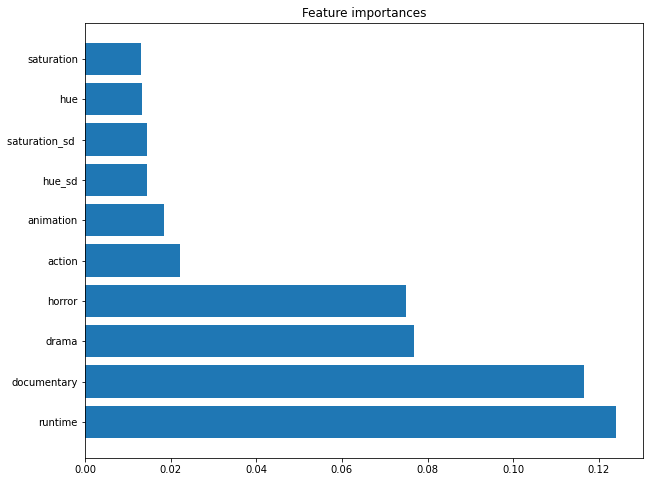

In [32]:
importances_order = np.argsort(rfreg.feature_importances_)[::-1]
print(train_X.columns[importances_order[:10]])
print(rfreg.feature_importances_[importances_order[:10]])
plt.figure(figsize=(10, 8))
plt.title("Feature importances")
plt.barh(range(10),rfreg.feature_importances_[importances_order[:10]])
plt.yticks(range(10), train_X.columns[importances_order[:10]], rotation='horizontal')
plt.savefig('../plots/feature_importancvce.png')
plt.show()

# XGBoost

### regression

In [61]:
import xgboost as xgb
xgreg = xgb.XGBRegressor(objective ='reg:squarederror')
xgreg.fit(train_X, train_y)

print('Train R^2: ', xgreg.score(train_X, train_y))
print('Train MSE: ', mean_squared_error(xgreg.predict(train_X), train_y))

print('Valid R^2: ', xgreg.score(val_X, val_y))
print('Valid MSE: ', mean_squared_error(xgreg.predict(val_X), val_y))

print('Test R^2: ', xgreg.score(test_X, test_y))
print('Test MSE: ', mean_squared_error(xgreg.predict(test_X), test_y))

Train R^2:  0.6506230970382416
Train MSE:  0.5160540690109419
Valid R^2:  0.38669584852279837
Valid MSE:  0.8745404915542743
Test R^2:  0.4384435177634063
Test MSE:  0.8375692544852968


### classification

In [62]:
# XGBoost 5 classes
xgb_5_cls = xgb.XGBClassifier(objective ='multi:softmax').fit(train_X, train_y_5_cls)

print('Train Accuracy: ', xgb_5_cls.score(train_X, train_y_5_cls))
print('Train MSE: ', mean_squared_error(np.apply_along_axis(cls_5_to_value, 0, xgb_5_cls.predict(train_X)), train_y_5_cls.apply(cls_5_to_value)))

print('Valid Accuracy: ', xgb_5_cls.score(val_X, val_y_5_cls))
print('Valid MSE: ', mean_squared_error(np.apply_along_axis(cls_5_to_value, 0, xgb_5_cls.predict(val_X)), val_y_5_cls.apply(cls_5_to_value)))

print('Test Accuracy: ', xgb_5_cls.score(test_X, test_y_5_cls))
print('Test MSE: ', mean_squared_error(np.apply_along_axis(cls_5_to_value, 0, xgb_5_cls.predict(test_X)), test_y_5_cls.apply(cls_5_to_value)))

Train Accuracy:  0.8343944217068364
Train MSE:  0.7315446415037138
Valid Accuracy:  0.6403818953323904
Valid MSE:  1.5855728429985856
Test Accuracy:  0.6584158415841584
Test MSE:  1.502121640735502


In [63]:
# XGBoost 10 classes
xgb_10_cls = xgb.XGBClassifier(objective ='multi:softmax').fit(train_X, train_y_10_cls)

print('Train Accuracy: ', xgb_10_cls.score(train_X, train_y_10_cls))
print('Train MSE: ', mean_squared_error(np.apply_along_axis(cls_10_to_value, 0, xgb_10_cls.predict(train_X)), train_y_10_cls.apply(cls_10_to_value)))

print('Valid Accuracy: ', xgb_10_cls.score(val_X, val_y_10_cls))
print('Valid MSE: ', mean_squared_error(np.apply_along_axis(cls_10_to_value, 0, xgb_10_cls.predict(val_X)), val_y_10_cls.apply(cls_10_to_value)))

print('Test Accuracy: ', xgb_10_cls.score(test_X, test_y_10_cls))
print('Test MSE: ', mean_squared_error(np.apply_along_axis(cls_10_to_value, 0, xgb_10_cls.predict(test_X)), test_y_10_cls.apply(cls_10_to_value)))

Train Accuracy:  0.7816431711383962
Train MSE:  0.4185235713202971
Valid Accuracy:  0.413012729844413
Valid MSE:  1.1739745403111739
Test Accuracy:  0.41336633663366334
Test MSE:  1.1488684582743989


In [64]:
# XGBoost 20 classes
xgb_20_cls = xgb.XGBClassifier(objective ='multi:softmax').fit(train_X, train_y_20_cls)

print('Train Accuracy: ', xgb_20_cls.score(train_X, train_y_20_cls))
print('Train MSE: ', mean_squared_error(np.apply_along_axis(cls_20_to_value, 0, xgb_20_cls.predict(train_X)), train_y_20_cls.apply(cls_20_to_value)))

print('Valid Accuracy: ', xgb_20_cls.score(val_X, val_y_20_cls))
print('Valid MSE: ', mean_squared_error(np.apply_along_axis(cls_20_to_value, 0, xgb_20_cls.predict(val_X)), val_y_20_cls.apply(cls_20_to_value)))

print('Test Accuracy: ', xgb_20_cls.score(test_X, test_y_20_cls))
print('Test MSE: ', mean_squared_error(np.apply_along_axis(cls_20_to_value, 0, xgb_20_cls.predict(test_X)), test_y_20_cls.apply(cls_20_to_value)))

Train Accuracy:  0.8081703804759739
Train MSE:  0.24238290131878126
Valid Accuracy:  0.22065063649222066
Valid MSE:  1.134016973125884
Test Accuracy:  0.22772277227722773
Test MSE:  1.091495756718529


### compare

In [65]:
print("XGBoost Regression vs XGBoost Classification")
test_y_5_pred = np.apply_along_axis(cls_5_to_value, 0, xgb_5_cls.predict(test_X))
test_y_10_pred = np.apply_along_axis(cls_10_to_value, 0, xgb_10_cls.predict(test_X))
test_y_20_pred = np.apply_along_axis(cls_20_to_value, 0, xgb_20_cls.predict(test_X))

print("Test R^2")
print("Reg:", xgreg.score(test_X, test_y))
print("Cls (5 cls):", r2_score(test_y, test_y_5_pred))
print("Cls (10 cls):", r2_score(test_y, test_y_10_pred))
print("Cls (20 cls):", r2_score(test_y, test_y_20_pred))

print("Test Accuracy")
xg_y_5_cls = np.apply_along_axis(to_5_classes, 0, xgreg.predict(test_X))
xg_y_10_cls = np.apply_along_axis(to_10_classes, 0, xgreg.predict(test_X))
xg_y_20_cls = np.apply_along_axis(to_20_classes, 0, xgreg.predict(test_X))
print("Reg (5 cls):", accuracy_score(test_y_5_cls, xg_y_5_cls))
print("Cls (5 cls):", xgb_5_cls.score(test_X, test_y_5_cls))
print("Reg (10 cls):", accuracy_score(test_y_10_cls, xg_y_10_cls))
print("Cls (10 cls):", xgb_10_cls.score(test_X, test_y_10_cls))
print("Reg (20 cls):", accuracy_score(test_y_20_cls, xg_y_20_cls))
print("Cls (20 cls):", xgb_20_cls.score(test_X, test_y_20_cls))

print("Test MSE")
print("Reg:", mean_squared_error(xgreg.predict(test_X), test_y))
print("Cls (5 cls):", mean_squared_error(test_y_5_pred, test_y_5_cls.apply(cls_5_to_value)))
print("Cls (10 cls):", mean_squared_error(test_y_10_pred, test_y_10_cls.apply(cls_10_to_value)))
print("Cls (20 cls):", mean_squared_error(test_y_20_pred, test_y_20_cls.apply(cls_20_to_value)))

XGBoost Regression vs XGBoost Classification
Test R^2
Reg: 0.4384435177634063
Cls (5 cls): 0.19343074338304445
Cls (10 cls): 0.2970580282348778
Cls (20 cls): 0.2937863363315256
Test Accuracy
Reg (5 cls): 0.6697312588401697
Cls (5 cls): 0.6584158415841584
Reg (10 cls): 0.43316831683168316
Cls (10 cls): 0.41336633663366334
Reg (20 cls): 0.22984441301272984
Cls (20 cls): 0.22772277227722773
Test MSE
Reg: 0.8375692544852968
Cls (5 cls): 1.502121640735502
Cls (10 cls): 1.1488684582743989
Cls (20 cls): 1.091495756718529


# Support Vector Machine

### regression

In [10]:
from sklearn.svm import SVR

svr = SVR(gamma='scale', C=1.0, epsilon=0.2)
svr.fit(train_X, train_y)

print('Train R^2: ', svr.score(train_X, train_y))
print('Train MSE: ', mean_squared_error(svr.predict(train_X), train_y))

print('Valid R^2: ', svr.score(val_X, val_y))
print('Valid MSE: ', mean_squared_error(svr.predict(val_X), val_y))

print('Test R^2: ', svr.score(test_X, test_y))
print('Test MSE: ', mean_squared_error(svr.predict(test_X), test_y))

Train R^2:  0.6117073347182355
Train MSE:  0.5735353659245503
Valid R^2:  0.34876421444251493
Valid MSE:  0.9286290703355009
Test R^2:  0.3768354104581578
Test MSE:  0.9294585980120388


### classification

In [15]:
from sklearn.svm import SVC

svc_5_cls = SVC(gamma='scale', C=1.0).fit(train_X, train_y_5_cls)

print('Train Accuracy: ', svc_5_cls.score(train_X, train_y_5_cls))
print('Train MSE: ', mean_squared_error(np.apply_along_axis(cls_5_to_value, 0, svc_5_cls.predict(train_X)), train_y_5_cls.apply(cls_5_to_value)))

print('Valid Accuracy: ', svc_5_cls.score(val_X, val_y_5_cls))
print('Valid MSE: ', mean_squared_error(np.apply_along_axis(cls_5_to_value, 0, svc_5_cls.predict(val_X)), val_y_5_cls.apply(cls_5_to_value)))

print('Test Accuracy: ', svc_5_cls.score(test_X, test_y_5_cls))
print('Test MSE: ', mean_squared_error(np.apply_along_axis(cls_5_to_value, 0, svc_5_cls.predict(test_X)), test_y_5_cls.apply(cls_5_to_value)))

Train Accuracy:  0.7683795664696074
Train MSE:  1.147491283916932
Valid Accuracy:  0.6223479490806223
Valid MSE:  1.7043847241867043
Test Accuracy:  0.6474540311173974
Test MSE:  1.6364922206506365


In [ ]:
svc_10_cls = SVC(gamma='scale', C=1.0).fit(train_X, train_y_10_cls)

print('Train Accuracy: ', svc_10_cls.score(train_X, train_y_10_cls))
print('Train MSE: ', mean_squared_error(np.apply_along_axis(cls_10_to_value, 0, svc_10_cls.predict(train_X)), train_y_10_cls.apply(cls_10_to_value)))

print('Valid Accuracy: ', svc_10_cls.score(val_X, val_y_10_cls))
print('Valid MSE: ', mean_squared_error(np.apply_along_axis(cls_10_to_value, 0, svc_10_cls.predict(val_X)), val_y_10_cls.apply(cls_10_to_value)))

print('Test Accuracy: ', svc_10_cls.score(test_X, test_y_10_cls))
print('Test MSE: ', mean_squared_error(np.apply_along_axis(cls_10_to_value, 0, svc_10_cls.predict(test_X)), test_y_10_cls.apply(cls_10_to_value)))

Train Accuracy:  0.5760194027588298
Train MSE:  1.0870092466272547
Valid Accuracy:  0.39816124469589814
Valid MSE:  1.2577793493635079
Test Accuracy:  0.4055869872701556
Test MSE:  1.3125884016973126

### compare

In [16]:
print("Support Vector Machine Regression vs Classification")
test_y_5_pred = np.apply_along_axis(cls_5_to_value, 0, svc_5_cls.predict(test_X))
#test_y_10_pred = np.apply_along_axis(cls_10_to_value, 0, svc_10_cls.predict(test_X))
#test_y_20_pred = np.apply_along_axis(cls_20_to_value, 0, svc_20_cls.predict(test_X))

print("Test R^2")
print("Reg:", svr.score(test_X, test_y))
print("Cls (5 cls):", r2_score(test_y, test_y_5_pred))
#print("Cls (10 cls):", r2_score(test_y, test_y_10_pred))
#print("Cls (20 cls):", r2_score(test_y, test_y_20_pred))

print("Test Accuracy")
svr_y_5_cls = np.apply_along_axis(to_5_classes, 0, svr.predict(test_X))
#svr_y_10_cls = np.apply_along_axis(to_10_classes, 0, svr.predict(test_X))
#svr_y_20_cls = np.apply_along_axis(to_20_classes, 0, svr.predict(test_X))
print("Reg (5 cls):", accuracy_score(test_y_5_cls, svr_y_5_cls))
print("Cls (5 cls):", svc_5_cls.score(test_X, test_y_5_cls))
# print("Reg (10 cls):", accuracy_score(test_y_10_cls, svr_y_10_cls))
# print("Cls (10 cls):", svc_10_cls.score(test_X, test_y_10_cls))
# print("Reg (20 cls):", accuracy_score(test_y_20_cls, svr_y_20_cls))
# print("Cls (20 cls):", svc_20_cls.score(test_X, test_y_20_cls))

print("Test MSE")
print("Reg:", mean_squared_error(svr.predict(test_X), test_y))
print("Cls (5 cls):", mean_squared_error(test_y_5_pred, test_y_5_cls.apply(cls_5_to_value)))
# print("Cls (10 cls):", mean_squared_error(test_y_10_pred, test_y_10_cls.apply(cls_10_to_value)))
# print("Cls (20 cls):", mean_squared_error(test_y_20_pred, test_y_20_cls.apply(cls_20_to_value)))

Support Vector Machine Regression vs Classification
Test R^2
Reg: 0.3768354104581578
Cls (5 cls): 0.10969439698709926
Test Accuracy
Reg (5 cls): 0.655940594059406
Cls (5 cls): 0.6474540311173974
Test MSE
Reg: 0.9294585980120388
Cls (5 cls): 1.6364922206506365
